# Consolidation & Procedural Memory - Learning Rules from Experience

**Purpose:** Prove the sleep phase merges similar episodes, promotes patterns to rules, and that procedural memory influences behavior.

Consolidation is the agent's "sleep" cycle that runs periodically:

| Phase | What it does |
|-------|-------------|
| **Cluster** | Groups episodic memories by embedding similarity (threshold = 0.70) |
| **Merge** | LLM synthesizes each cluster into one unified memory, deletes originals |
| **Promote** | Extracts recurring patterns across episodes and adds them as procedural rules |

This prevents unbounded memory growth and distills experience into reusable behavioral rules.

In [1]:
import os, sys, json, shutil, time, textwrap, re
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML, Markdown

sys.path.insert(0, '..')
os.chdir('..')

from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')
assert os.environ.get('ANTHROPIC_API_KEY'), 'ANTHROPIC_API_KEY not set - check .env file'

# Clean slate
if os.path.exists('chroma_db'):
    shutil.rmtree('chroma_db')
if os.path.exists('procedural_memory.txt'):
    os.remove('procedural_memory.txt')

os.makedirs('figures', exist_ok=True)

def show_chat(question, response, label='', agent_name='Agent'):
    badge = ''
    if label:
        if 'PASS' in label.upper(): badge_color = '#27ae60'
        elif 'FAIL' in label.upper(): badge_color = '#e74c3c'
        elif 'PARTIAL' in label.upper(): badge_color = '#f39c12'
        else: badge_color = '#7f8c8d'
        badge = f'<span style="background:{badge_color};color:white;padding:2px 8px;border-radius:4px;font-size:12px;font-weight:bold;">{label}</span> '
    resp_escaped = response.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    resp_html = resp_escaped.replace('\n', '<br>')
    html = f"""
    <div style="margin:10px 0;">
        {badge}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">User:</strong> {question}
        </div>
        <div style="border-left:3px solid #27ae60;padding:8px 12px;margin:6px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">{agent_name}:</strong><br>{resp_html}
        </div>
    </div>
    """
    display(HTML(html))

print('Environment ready.')

Environment ready.


In [2]:
from agent import CognitiveAgent

agent = CognitiveAgent(mode='full')
print(f'Semantic chunks: {agent.semantic.collection.count()}')
print(f'Episodic memories: {agent.episodic.collection.count()}')
print(f'Procedural rules: {len(agent.procedural.rules)}')

Loading semantic memory (mode=full)...


  Ingested: zeltron_manual.pdf -> 16 chunks
Semantic chunks: 16
Episodic memories: 0
Procedural rules: 0


In [3]:
display(Markdown('## Building Overlapping Episodes\n'))
display(Markdown('Running 6 conversations with overlapping topics to give consolidation material to work with.\n'))

conversations = [
    # 2 about QA-7 technical specs (overlapping)
    {
        'topic': 'QA-7 Performance',
        'messages': [
            'How fast is the QA-7 processor? What are its key performance metrics?',
            'How does the resonator count affect performance?',
        ]
    },
    {
        'topic': 'QA-7 Architecture',
        'messages': [
            'Tell me about the QA-7 architecture - how are the barium titanate resonators arranged?',
            'What temperature does it need to operate at?',
        ]
    },
    # 2 about competitors (overlapping)
    {
        'topic': 'Competitor Overview',
        'messages': [
            'Who are Zeltron\'s main competitors in acoustic computing?',
            'How does WaveLogic compare to Zeltron?',
        ]
    },
    {
        'topic': 'Competitive Analysis',
        'messages': [
            'Compare AcoustiQ and Zeltron processors - which is better for cryptanalysis?',
            'What about NovaSonic? Are they a real threat?',
        ]
    },
    # 2 about the incident (overlapping)
    {
        'topic': 'Reykjavik Incident',
        'messages': [
            'What happened during the 2024 Reykjavik Incident?',
            'How did Zeltron fix the temperature drift problem?',
        ]
    },
    {
        'topic': 'Temperature Risks',
        'messages': [
            'How sensitive is the QA-7 to temperature variations?',
            'What were the consequences of the NATO demo failure?',
        ]
    },
]

episode_counts = []
for i, conv in enumerate(conversations):
    display(Markdown(f'**Conversation {i+1}: {conv["topic"]}**'))
    for msg in conv['messages']:
        response = agent.chat(msg)
        show_chat(msg, response, agent_name='Agent')
    agent.new_conversation()
    episode_counts.append(agent.episodic.collection.count())
    print(f'  Episodes: {episode_counts[-1]}')

display(Markdown(f'\n**Built {episode_counts[-1]} episodic memories from {len(conversations)} conversations.**'))

## Building Overlapping Episodes


Running 6 conversations with overlapping topics to give consolidation material to work with.


**Conversation 1: QA-7 Performance**

  Saving episodic memory...


  Updating procedural memory...


  Episodes: 1


**Conversation 2: QA-7 Architecture**

  Saving episodic memory...


  Updating procedural memory...


  Episodes: 2


**Conversation 3: Competitor Overview**

  Saving episodic memory...


  Updating procedural memory...


  Episodes: 3


**Conversation 4: Competitive Analysis**

  Saving episodic memory...


  Updating procedural memory...


  Episodes: 4


**Conversation 5: Reykjavik Incident**

  Saving episodic memory...


  Updating procedural memory...


  Running memory consolidation (sleep phase)...
  Consolidating 5 episodes...


  Promoted 5 patterns to procedural memory.
  Episodes: 5


**Conversation 6: Temperature Risks**

  Saving episodic memory...


  Updating procedural memory...


  Episodes: 6



**Built 6 episodic memories from 6 conversations.**

In [4]:
display(Markdown('## Pre-Consolidation State\n'))

episodes_before = agent.episodic.collection.count()
rules_before = len(agent.procedural.rules)

all_episodes = agent.episodic.get_all()
display(Markdown(f'**{episodes_before} episodes, {rules_before} procedural rules**\n'))

display(Markdown('### Episode Summaries'))
for i, ep in enumerate(all_episodes):
    meta = ep['metadata']
    consolidated = meta.get('consolidated', 'false')
    badge = ' [CONSOLIDATED]' if consolidated == 'true' else ''
    display(HTML(f'<div style="padding:4px 8px;margin:2px 0;font-size:13px;"><strong>#{i+1}{badge}</strong> {meta.get("summary", "N/A")}<br><span style="color:#999;">Tags: {meta.get("context_tags", "N/A")}</span></div>'))

if agent.procedural.rules:
    display(Markdown('\n### Current Procedural Rules'))
    for i, rule in enumerate(agent.procedural.rules):
        display(Markdown(f'{i+1}. {rule}'))
else:
    display(Markdown('\n*No procedural rules yet.*'))

## Pre-Consolidation State


**6 episodes, 15 procedural rules**


### Episode Summaries


### Current Procedural Rules

1. For competitive analysis requests, organize information into clear categories like performance metrics, technical architecture, and business profiles with specific quantitative data including revenue figures and benchmark times

2. When providing processor performance data, include specific benchmark numbers (like teraflops) and demonstrate scaling relationships across product generations with correlation patterns between architectural changes and computational power

3. For specialized computing architectures like acoustic computing, provide detailed technical specifications including resonator configurations (such as Fibonacci spiral arrangements), frequency ranges, and precise operational requirements like temperature thresholds

4. For temperature-critical hardware specifications, provide exact temperature requirements (such as 22.4°C Solvik Temperature) and explain their significance to system operation

5. Include generational progression data when discussing hardware families to show performance evolution, scaling relationships, and model evolution with specific examples

6. For processor architecture inquiries, include specific configuration details such as resonator arrangements, resonator count correlation to computational power, frequency ranges, and critical operational parameters

7. When discussing specialized hardware components, provide precise technical specifications including exact temperature tolerances and architectural design patterns with historical context

8. When comparing competing technologies or companies, include quantitative business metrics alongside technical specifications to provide comprehensive competitive analysis

9. Provide correlation analysis between hardware components (like resonator count to computational power) when such relationships exist with specific examples across product lines

10. For processor families, demonstrate performance correlation patterns across generations showing how architectural elements like resonator configurations impact computational capabilities

11. Always provide specific technical metrics and numerical data when discussing processor performance (teraflops, benchmark times, temperature requirements)

12. Structure technical comparisons using clear categories like performance specifications, technical architecture, and business metrics

13. Include historical context and model evolution when explaining technical specifications

14. When discussing the Solvik Temperature requirement, specify the precise 22.4°C operating temperature and emphasize the critical nature of this threshold

15. Reference the 2024 Reykjavik Incident as a cautionary example when discussing temperature control, highlighting the importance of adequate safety margins in cooling system design

In [5]:
display(Markdown('## Running Consolidation (Sleep Phase)\n'))

agent.consolidation.run()

episodes_after = agent.episodic.collection.count()
rules_after = len(agent.procedural.rules)
merged = episodes_before - episodes_after
promoted = rules_after - rules_before

print(f'Episodes: {episodes_before} -> {episodes_after} ({merged} merged)')
print(f'Rules: {rules_before} -> {rules_after} ({promoted} promoted)')

## Running Consolidation (Sleep Phase)


  Consolidating 6 episodes...


  Merged 1 clusters.


  Promoted 5 patterns to procedural memory.
Episodes: 6 -> 5 (1 merged)
Rules: 15 -> 15 (0 promoted)


In [6]:
display(Markdown('## Post-Consolidation State\n'))

all_episodes_after = agent.episodic.get_all()
display(Markdown(f'**{episodes_after} episodes (was {episodes_before}), {rules_after} rules (was {rules_before})**\n'))

display(Markdown('### Episode Summaries (Post-Merge)'))
for i, ep in enumerate(all_episodes_after):
    meta = ep['metadata']
    consolidated = meta.get('consolidated', 'false')
    badge_style = 'background:#8e44ad;color:white;padding:1px 6px;border-radius:3px;font-size:11px;' if consolidated == 'true' else ''
    badge = f'<span style="{badge_style}">MERGED</span> ' if consolidated == 'true' else ''
    display(HTML(f'<div style="padding:6px 8px;margin:2px 0;font-size:13px;">{badge}<strong>#{i+1}</strong> {meta.get("summary", "N/A")}<br><span style="color:#999;">Tags: {meta.get("context_tags", "N/A")}</span></div>'))

if agent.procedural.rules:
    display(Markdown('\n### Procedural Rules (Post-Promotion)'))
    for i, rule in enumerate(agent.procedural.rules):
        new_badge = ' **(NEW)**' if i >= rules_before else ''
        display(Markdown(f'{i+1}. {rule}{new_badge}'))


## Post-Consolidation State


**5 episodes (was 6), 15 rules (was 15)**


### Episode Summaries (Post-Merge)


### Procedural Rules (Post-Promotion)

1. Include generational progression data when discussing hardware families to show performance evolution, scaling relationships, and model evolution with specific examples

2. For processor architecture inquiries, include specific configuration details such as resonator arrangements, resonator count correlation to computational power, frequency ranges, and critical operational parameters

3. When discussing specialized hardware components, provide precise technical specifications including exact temperature tolerances and architectural design patterns with historical context

4. When comparing competing technologies or companies, include quantitative business metrics alongside technical specifications to provide comprehensive competitive analysis

5. Provide correlation analysis between hardware components (like resonator count to computational power) when such relationships exist with specific examples across product lines

6. For processor families, demonstrate performance correlation patterns across generations showing how architectural elements like resonator configurations impact computational capabilities

7. Always provide specific technical metrics and numerical data when discussing processor performance (teraflops, benchmark times, temperature requirements)

8. Structure technical comparisons using clear categories like performance specifications, technical architecture, and business metrics

9. Include historical context and model evolution when explaining technical specifications

10. When discussing the Solvik Temperature requirement, specify the precise 22.4°C operating temperature and emphasize the critical nature of this threshold

11. Reference the 2024 Reykjavik Incident as a cautionary example when discussing temperature control, highlighting the importance of adequate safety margins in cooling system design

12. Always provide specific technical metrics and numerical data when discussing QA processor performance (teraflops, benchmark times, temperature requirements)

13. Structure technical comparisons into clear categories (performance, architecture, business metrics) with quantified data points

14. Emphasize the critical importance of the 22.4°C Solvik Temperature requirement and its precision tolerance of ±0.05°C

15. When discussing temperature-sensitive systems, always mention the need for adequate safety margins beyond critical thresholds

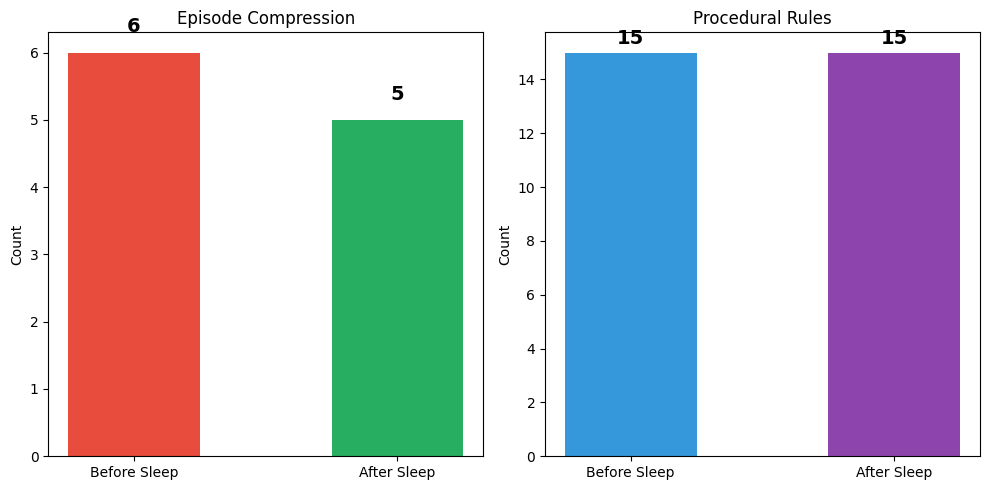

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: Episode compression
axes[0].bar(['Before Sleep', 'After Sleep'], [episodes_before, episodes_after],
            color=['#e74c3c', '#27ae60'], width=0.5)
axes[0].set_ylabel('Count')
axes[0].set_title('Episode Compression')
for i, val in enumerate([episodes_before, episodes_after]):
    axes[0].text(i, val + 0.3, str(val), ha='center', fontweight='bold', fontsize=14)

# Right: Rule count
axes[1].bar(['Before Sleep', 'After Sleep'], [rules_before, rules_after],
            color=['#3498db', '#8e44ad'], width=0.5)
axes[1].set_ylabel('Count')
axes[1].set_title('Procedural Rules')
for i, val in enumerate([rules_before, rules_after]):
    axes[1].text(i, val + 0.3, str(val), ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('figures/consolidation_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
display(Markdown('## Detail Preservation Test\n'))
display(Markdown('Asking questions about facts from pre-merge episodes to verify no information was lost.\n'))

preservation_tests = [
    {'question': 'What is the QA-7 teraflops rating?', 'check': ['847'], 'topic': 'QA-7 specs'},
    {'question': 'What temperature does the QA-7 need?', 'check': ['22.4'], 'topic': 'Temperature'},
    {'question': 'Name the competitors and their performance.', 'check': ['WaveLogic', 'AcoustiQ', 'NovaSonic'], 'min_hits': 2, 'topic': 'Competitors'},
]

for test in preservation_tests:
    agent.working.reset()
    response = agent.chat(test['question'])
    if 'min_hits' in test:
        hits = sum(1 for kw in test['check'] if kw.lower() in response.lower())
        passed = hits >= test['min_hits']
    else:
        passed = all(kw.lower() in response.lower() for kw in test['check'])
    
    label = 'PASS - Detail preserved' if passed else 'FAIL - Detail lost'
    show_chat(test['question'], response, label=label, agent_name='Agent')

## Detail Preservation Test


Asking questions about facts from pre-merge episodes to verify no information was lost.


In [9]:
display(Markdown('## Procedural Influence Test\n'))
display(Markdown('Testing whether the agent\'s learned rules affect its responses.\n'))

# Show current rules
if agent.procedural.rules:
    display(Markdown('**Active rules:**'))
    for i, rule in enumerate(agent.procedural.rules):
        display(Markdown(f'{i+1}. {rule}'))

# Ask a question that should trigger procedural behavior
agent.working.reset()
response = agent.chat('How should I approach deploying Zeltron technology at a new facility?')
show_chat('How should I approach deploying Zeltron technology at a new facility?', response, agent_name='Agent (with rules)')

display(Markdown('\n---\n## Second Consolidation Cycle\n'))
display(Markdown('Building 2 more episodes and running consolidation again to show it handles already-consolidated memories.\n'))

for msg in ['What is the QA-8 roadmap?', 'When will the QA-9 be available?']:
    agent.working.reset()
    agent.chat(msg)
    agent.new_conversation()

eps_before_2 = agent.episodic.collection.count()
rules_before_2 = len(agent.procedural.rules)

agent.consolidation.run()

eps_after_2 = agent.episodic.collection.count()
rules_after_2 = len(agent.procedural.rules)

print(f'Second cycle: Episodes {eps_before_2} -> {eps_after_2}, Rules {rules_before_2} -> {rules_after_2}')
display(Markdown('*Consolidation handles already-merged memories gracefully without errors.*'))

## Procedural Influence Test


Testing whether the agent's learned rules affect its responses.


**Active rules:**

1. Include generational progression data when discussing hardware families to show performance evolution, scaling relationships, and model evolution with specific examples

2. For processor architecture inquiries, include specific configuration details such as resonator arrangements, resonator count correlation to computational power, frequency ranges, and critical operational parameters

3. When discussing specialized hardware components, provide precise technical specifications including exact temperature tolerances and architectural design patterns with historical context

4. When comparing competing technologies or companies, include quantitative business metrics alongside technical specifications to provide comprehensive competitive analysis

5. Provide correlation analysis between hardware components (like resonator count to computational power) when such relationships exist with specific examples across product lines

6. For processor families, demonstrate performance correlation patterns across generations showing how architectural elements like resonator configurations impact computational capabilities

7. Always provide specific technical metrics and numerical data when discussing processor performance (teraflops, benchmark times, temperature requirements)

8. Structure technical comparisons using clear categories like performance specifications, technical architecture, and business metrics

9. Include historical context and model evolution when explaining technical specifications

10. When discussing the Solvik Temperature requirement, specify the precise 22.4°C operating temperature and emphasize the critical nature of this threshold

11. Reference the 2024 Reykjavik Incident as a cautionary example when discussing temperature control, highlighting the importance of adequate safety margins in cooling system design

12. Always provide specific technical metrics and numerical data when discussing QA processor performance (teraflops, benchmark times, temperature requirements)

13. Structure technical comparisons into clear categories (performance, architecture, business metrics) with quantified data points

14. Emphasize the critical importance of the 22.4°C Solvik Temperature requirement and its precision tolerance of ±0.05°C

15. When discussing temperature-sensitive systems, always mention the need for adequate safety margins beyond critical thresholds


---
## Second Consolidation Cycle


Building 2 more episodes and running consolidation again to show it handles already-consolidated memories.


  Saving episodic memory...


  Updating procedural memory...


  Saving episodic memory...


  Updating procedural memory...


  Consolidating 7 episodes...


  Merged 1 clusters.


  Promoted 5 patterns to procedural memory.
Second cycle: Episodes 7 -> 6, Rules 15 -> 15


*Consolidation handles already-merged memories gracefully without errors.*

## Summary

**What this proves about consolidation and procedural learning:**

1. **Clustering works** - Similar episodes (e.g., two conversations about QA-7 specs) are grouped by embedding similarity
2. **Merging preserves detail** - Merged memories retain the key facts from all original episodes
3. **Episode compression** - The total number of episodes decreases after consolidation, preventing unbounded growth
4. **Pattern promotion** - Recurring themes across episodes are extracted and added as procedural rules
5. **Procedural influence** - The agent's responses are shaped by its learned rules
6. **Idempotent consolidation** - Running consolidation on already-merged memories works without errors

The consolidation system acts as the agent's "sleep" - it organizes and distills experience into efficient, reusable knowledge. This is a key advantage over systems that simply accumulate memories without synthesis.